<a href="https://colab.research.google.com/github/peppefdf/Generate_stops/blob/main/Generate_stops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


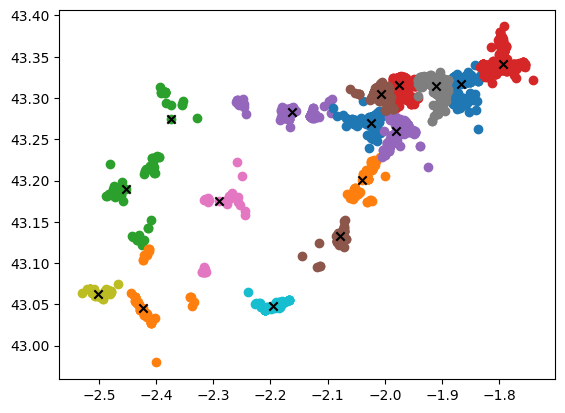

Stops for cluster  0 :
                          highway                 name public_transport  \
element_type osmid                                                        
node         2956936409  bus_stop  Lanbarren poligonoa         platform   
             2956936410  bus_stop  Lintzirin poligonoa         platform   
             2956936415  bus_stop       Oliden kanpina         platform   

                        shelter                   geometry bench  bin  bus  \
element_type osmid                                                           
node         2956936409     yes  POINT (-1.86780 43.31963)   NaN  NaN  NaN   
             2956936410     yes  POINT (-1.87702 43.31366)   yes  yes  yes   
             2956936415     NaN  POINT (-1.87482 43.31547)   NaN  NaN  yes   

                         lit tactile_paving nodes area railway wikidata  
element_type osmid                                                       
node         2956936409  NaN            NaN   NaN  NaN     NaN

In [ ]:
#%pip install osmnx

import numpy as np
import osmnx as ox
import pandas as pd
import folium
import random
import sklearn
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from google.colab import drive

n_skip = 10
n_clusters = 16


workers_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Accessibility_Map/workers_eskuzaitzeta.csv", encoding='latin-1')
#print(workers_df.head)


#lat_lon = workers_df[['O_lat', 'O_long']][::n_skip] # take every n elements
lat_lon = workers_df[['O_lat', 'O_long']].values.tolist()


map = folium.Map(location=[43.13525255625577, -2.080054227169231], zoom_start=8)
for i in range(len(lat_lon)):
    lat = lat_lon[i][0]
    lon = lat_lon[i][1]
    folium.Marker((lat,lon)).add_to(map)

model = KMeans(n_clusters=n_clusters)
# fit the model
model.fit(lat_lon)
# assign a cluster to each example
yhat = model.predict(lat_lon)
# retrieve unique clusters
clusters = np.unique(yhat)

centers = np.array(model.cluster_centers_)

cont_centers = 0
for cluster in clusters:
 X = []
 Y = []
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)
 # create scatter of these samples
 dist = []
 for i_cl in range(len(row_ix[0])):

     # calculate Euclidean distance of each point from cluster center
     d = sum((p-q)**2 for p, q in zip(centers[cont_centers], lat_lon[row_ix[0][i_cl]]))**.5
     dist.append(d)
     X.append(lat_lon[row_ix[0][i_cl]][0])
     Y.append(lat_lon[row_ix[0][i_cl]][1])

 # find index of minimum distance from cluster center
 index_min = np.argmin(dist)
 # assign closest point to cluster center: this tries to avoid the cluster center to fall in the middle of nowhere
 centers[cont_centers][0] = lat_lon[row_ix[0][index_min]][0]
 centers[cont_centers][1] = lat_lon[row_ix[0][index_min]][1]

 cont_centers+=1
 plt.scatter(Y,X)

# plot centers
#centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
plt.show()

tags = {'highway':'bus_stop',
        'bus':'yes',
        'public_transport':'stop_position',
        'public_transport':'platform'}
for i in range(len(centers)):
    lat = centers[i][0]
    lon = centers[i][1]
    #G = ox.graph_from_point((lat, lon), dist=2000, network_type='drive', simplify=False)
    #nodes, edges = ox.graph_to_gdfs(G)
    #closest_p = ox.distance.nearest_nodes(G, lon, lat, return_dist=False)
    try:
       # get 3 closest (1000 meters) bus stops
       gdf = ox.features.features_from_point((lat, lon), dist=1000, tags=tags)
       print('Stops for cluster ',i,':')
       print(gdf.head(3))
    except:
       print('stops not found for cluster ',i)
       print(centers[i])
    print()

map
